# Вступление
![Titanic](https://img.rl0.ru/3ea9d43d3efd0c5d7852fc5606143dcc/c615x400i/news.rambler.ru/img/2018/11/11041133.160262.4433.jpeg)


Титаник — известная задача на Kaggle, ориентированная в большей мере на начинающих в машинном обучении. Датасет Титаник содержит данные пассажиров корабля. Цель задачи — построить модель, которая лучшим образом сможет предсказать, остался ли произвольный пассажир в живых или нет.

# Загрузка данных
Загрузим наши данные и импортируем необходимые библиотеки.

In [1]:
# Импорт необходимых данных для работы.
!kaggle competitions download -c titanic

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
# Импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
pd.options.mode.chained_assignment = None 

In [3]:
df_test = pd.read_csv('test.csv', index_col = 'PassengerId')
df_train = pd.read_csv('train.csv', index_col = 'PassengerId')
combine = [df_train, df_test]

# Dataset
Ниже представлен фрейм, над которым мы будем работать.

In [4]:
df_train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


Первым делом найдем количество пропущенных элементов в каждом столбце:

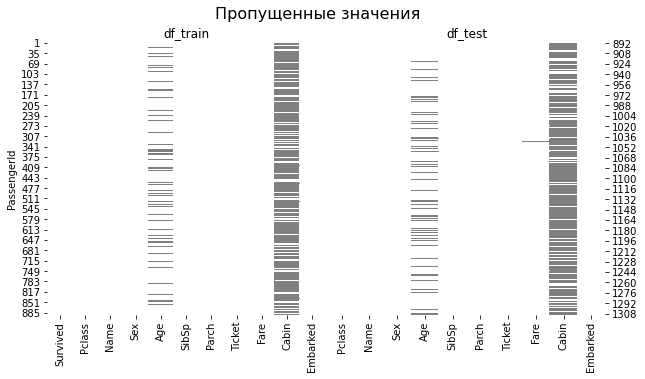

In [5]:
fig, (ax,ax2) = plt.subplots(figsize=(10, 5), ncols=2)
fig.suptitle("Пропущенные значения", fontsize=16)
fig.subplots_adjust(wspace=0.01)
sn.heatmap(df_train.isnull(), cbar = False, ax = ax, cmap=(['white', 'grey'])).set_title("df_train")
sn.heatmap(df_test.isnull(), cbar = False, ax = ax2, cmap=(['white', 'grey'])).set_title("df_test")
ax2.set_ylabel('')
ax2.yaxis.tick_right()
plt.setp(ax2.get_yticklabels(), rotation=0, ha="left", rotation_mode="anchor")
plt.show()

In [6]:
for dataset in combine:
    print(dataset.isnull().sum())

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64
Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64


Узнаем количество уникальных значений в каждом столбце:

In [7]:
for dataset in combine:
    print(dataset.nunique())

Survived      2
Pclass        3
Name        891
Sex           2
Age          88
SibSp         7
Parch         7
Ticket      681
Fare        248
Cabin       147
Embarked      3
dtype: int64
Pclass        3
Name        418
Sex           2
Age          79
SibSp         7
Parch         8
Ticket      363
Fare        169
Cabin        76
Embarked      3
dtype: int64


# Карта корреляции

Для удобства прогнозирования создадим карту корреляции:

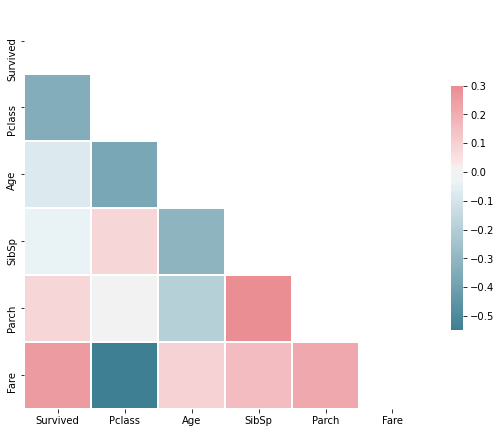

In [8]:
mask = np.triu(np.ones_like(df_train.corr(), dtype=np.bool))
f, ax = plt.subplots(figsize=(9, 9))
cmap = sn.diverging_palette(220, 10, as_cmap=True)
sn.heatmap(df_train.corr(), mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [9]:
df_train.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


# Изучение серий
## Survived
Уникальных значений 2: 
* 0 - погиб     
* 1 - выжил   

Пропущенные значения отсутствуют.

## Pclass
Класс билета.   
Уникальных значений 2: 
* 1 - 1ый класс 
* 2 - 2ой класс   
* 3 - 3ий класс 

Пропущенные значения отсутствуют.

## Name
ФИО пассажира.  
Вынесем [гоноративы](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D0%BD%D0%BE%D1%80%D0%B0%D1%82%D0%B8%D0%B2) в отдельную серию. Редко встречающиеся наименования объединим в одну группу 'Rare'. Преобразуем их в числа и удалим столбец Name.

In [10]:
for dataset in combine:
    dataset['Honor'] = dataset.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
    print(dataset['Honor'].value_counts())

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Ms                1
Lady              1
the Countess      1
Capt              1
Sir               1
Mme               1
Don               1
Jonkheer          1
Name: Honor, dtype: int64
Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dr          1
Ms          1
Dona        1
Name: Honor, dtype: int64


In [11]:
for dataset in combine:    
    dataset['Honor'] = dataset['Honor'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
# Mlle и Ms то же самое, что и Miss. Mme = Mrs.
    dataset['Honor'] = dataset['Honor'].replace('Mlle', 'Miss')
    dataset['Honor'] = dataset['Honor'].replace('Ms', 'Miss')
    dataset['Honor'] = dataset['Honor'].replace('Mme', 'Mrs')
# Преобразовываем с помощью LabelEncoder()
    dataset['Honor'] = LabelEncoder().fit_transform(dataset.Honor)
    dataset.drop(['Name'], axis = 1, inplace = True)

In [12]:
for dataset in combine:
    print(dataset['Honor'].value_counts())

2    517
1    185
3    126
0     40
4     22
5      1
Name: Honor, dtype: int64
2    240
1     79
3     72
0     21
4      6
Name: Honor, dtype: int64


## Sex
Уникальных значений 2: 
* female - женский пол  
* male - мужской пол

Пропущенные значения отсутствуют. Для удобства работы с данной серией необходимо заменить на числовые значения.
* 0 = female
* 1 = male

In [13]:
for dataset in combine:
    dataset['Sex'].loc[(dataset['Sex'] == 'male')] = 1
    dataset['Sex'].loc[(dataset['Sex'] == 'female')] = 0

## Age
Возраст пассажиров.  
263 пропущенных значений. Наибольший [коэффициент корреляции](#Карта-корреляции) с [Honor](#Name) и [Pclass](#Pclass), сгруппируем по [Sex](#Sex), [Pclass](#Pclass) и [Honor](#Name). Заполним пропущенные значения с помощью медианы каждой группы.

In [14]:
for dataset in combine:
    print(dataset.groupby(['Sex', 'Pclass', 'Honor'])['Age'].median())

Sex  Pclass  Honor
0    1       1        30.0
             3        40.0
             4        48.5
             5        33.0
     2       1        24.0
             3        32.0
     3       1        18.0
             3        31.0
1    1       0         4.0
             2        40.0
             4        49.0
     2       0         1.0
             2        31.0
             4        46.5
     3       0         4.0
             2        26.0
Name: Age, dtype: float64
Sex  Pclass  Honor
0    1       1        32.0
             3        48.0
             4        39.0
     2       1        19.5
             3        29.0
     3       1        22.0
             3        28.0
1    1       0         9.5
             2        42.0
             4        53.0
     2       0         5.0
             2        28.0
             4        35.5
     3       0         7.0
             2        25.0
Name: Age, dtype: float64


In [15]:
for dataset in combine:
    grp = dataset.groupby(['Sex', 'Pclass', 'Honor'])
    dataset.Age = grp.Age.apply(lambda x: x.fillna(x.median()))    

## SibSp
Количество братьев и сестер / супругов на борту Титаника.  
Пропущенные значения отсутствуют.
## Parch
Количество родителей / детей на борту Титаника.  
Пропущенные значения отсутствуют.

Объединим их в один столбец и назовём [Family](#Family).

In [16]:
for dataset in combine:
    dataset['Family'] = dataset['SibSp']+dataset['Parch']

Удалим [SibSp](#SibSp) и [Parch](#Parch).

In [17]:
for dataset in combine:
    dataset.drop(['SibSp', 'Parch'], axis = 1, inplace = True)

## Ticket
Номер билета.  
Пропущенные значения отсутствуют. Можем выделить приписку к номеру билета.

In [18]:
for dataset in combine:
# Разделим строку на номер билета и приписку к нему.
    dataset['Ticketname'] = dataset.Ticket.apply(lambda tick: tick.split(' '))
# Создадим пустую серию, которую заполним номером билета. 
    dataset['Ticketnumb'] = np.nan

После разделения строки, проверим тип ячеек.

In [19]:
print("Тип ячейки:\n", type(df_train.Ticketname.iloc[0]))

Тип ячейки:
 <class 'list'>


Узнаем длину каждого листа в серии:

In [20]:
a =[]
for dataset in combine:
    for i in dataset.Ticketname:
           a.append(len(i))
print ("Длина различных ячеек:\n",set(a))    

Длина различных ячеек:
 {1, 2, 3}


Теперь можем заполнять наши серии:

In [21]:
for dataset in combine:
    a = 0
    for i in dataset.Ticketname:
        if len(i) == 2:
            dataset['Ticketnumb'].iloc[a] =  i[1]
            dataset['Ticketname'].iloc[a] = i[0]
        elif len(i) == 1:
            dataset['Ticketname'].iloc[a] = 'STANDART'
            dataset['Ticketnumb'].iloc[a] =  i[0]
        elif len(i) == 3:
            dataset['Ticketname'].iloc[a] = i[0]+i[1]
            dataset['Ticketnumb'].iloc[a] =  i[2]
        a += 1

In [22]:
for dataset in combine:
# Некоторые значения отдичаются в написании, для этого все буквы переведем в верхний регистр, удалим '/' и '.'
    dataset.Ticketname = dataset.Ticketname.apply(lambda x: x.upper().translate(x.upper().maketrans("", "", "/.")))
    dataset.Ticketname.loc[(dataset.Ticketname == 'SOTONO2')] = 'STONO2'

Преобразуем текстовую информацию в числовую и удалим ненужные столбцы:

In [23]:
for dataset in combine:
    dataset.Ticketname = LabelEncoder().fit_transform(dataset.Ticketname)
    dataset.drop(['Ticket'], axis = 1, inplace = True)
    dataset.drop(['Ticketnumb'], axis = 1, inplace = True)

## Fare
Стоимость билета.  

In [24]:
for dataset in combine:
    dataset.Fare.fillna(dataset.Fare.mean(), inplace = True)

## Cabin
Номер кабины.  
Очень много пропущенных значений. Избавимся от них.

In [25]:
for dataset in combine:
    dataset.drop(['Cabin'], axis = 1, inplace = True)

## Embarked
Порт погрузки пассажира на Титаник.  
Уникальных значений 3:  
* C = Cherbourg 
* Q = Queenstown 
* S = Southampton

Как и с полом, заменим на числовые значения, где:
* 1 = C
* 2 = Q
* 3 = S 

In [26]:
for dataset in combine:
    dataset['Embarked'].loc[(dataset['Embarked'] == 'C')] = 1
    dataset['Embarked'].loc[(dataset['Embarked'] == 'Q')] = 2
    dataset['Embarked'].loc[(dataset['Embarked'] == 'S')] = 3

Пропущенных значений: 2. Их заменим на моду данной серии.

In [27]:
for dataset in combine:
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

## Прогнозирование
Это случай задачи классификации, воспользуемся алгоритмом [Decision Tree Classifier](https://www.machinelearningmastery.ru/scikit-learn-decision-trees-explained-803f3812290d/).

In [28]:
x_train = df_train[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Family', 'Honor', 'Ticketname']]
y_train = df_train.Survived
clf = DecisionTreeClassifier()
clf.fit(x_train,y_train)
x_test = df_test[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Family', 'Honor', 'Ticketname']]
y_pred = clf.predict(x_test)
y_test = pd.read_csv('gender_submission.csv', index_col = 'PassengerId')
print("Точность прогнозирования:", (metrics.accuracy_score(y_test, y_pred))*100)

Точность прогнозирования: 81.81818181818183


Создадим результат и подтвердим его в kaggle.

In [29]:
result = pd.DataFrame({'Survived': y_pred},index = df_test.index)
result.to_csv('submission.csv')
!kaggle competitions submit -c titanic -f submission.csv -m ""



Successfully submitted to Titanic: Machine Learning from Disaster


  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 20.7kB/s]
100%|##########| 3.18k/3.18k [00:03<00:00, 910B/s]  
